Analyzing ADWIN Data

In [63]:
import random
from river import drift
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

Preparing data

In [64]:
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

In [65]:
time_a_df.drop(columns=['Unnamed: 0'],inplace=True)
time_a_df['Date'] = pd.to_datetime(time_a_df['Date'], format='%Y-%m-%d')
time_b_decay_df.drop(columns=['Unnamed: 0'],inplace=True)
time_b_normal_df.drop(columns=['Unnamed: 0'],inplace=True)
time_b_growth_df.drop(columns=['Unnamed: 0'],inplace=True)
time_b_decay_df['Date'] = pd.to_datetime(time_b_decay_df['Date'], format='%Y-%m-%d')
time_b_normal_df['Date'] = pd.to_datetime(time_b_normal_df['Date'], format='%Y-%m-%d')
time_b_growth_df['Date'] = pd.to_datetime(time_b_growth_df['Date'], format='%Y-%m-%d')

In [ ]:
date = np.unique(time_a_df['Date']).astype('datetime64[D]')

all_data_decay = pd.concat([time_a_df,time_b_decay_df],axis=0)
all_data_growth = pd.concat([time_a_df,time_b_growth_df],axis=0)
all_data_normal = pd.concat([time_a_df,time_b_normal_df],axis=0)



#Launch date for the product
product_launch_date = np.max(np.unique(time_a_df['Date']).astype('datetime64[D]'))

Checking Daily Median 

In [ ]:
decay_median_engagement = all_data_decay.groupby('Date')['Engagement'].median()
growth_median_engagement = all_data_growth.groupby('Date')['Engagement'].median()
normal_median_engagement = all_data_normal.groupby('Date')['Engagement'].median()

all_dates = np.unique(all_data_decay['Date']).astype('datetime64[D]')



plt.figure(figsize=(10, 4))
sns.lineplot(x=all_dates, y=decay_median_engagement, marker="o", label="Decay",color="Blue")
sns.lineplot(x=all_dates, y=growth_median_engagement, marker="o", label="Growth",color="Green")
sns.lineplot(x=all_dates, y=normal_median_engagement, marker="o", label="Normal",color="Red")
plt.title("Median Engagement")
plt.savefig(f"Charts/Engagement_Median_Engagement.png")
plt.show()


Checking Daily Average

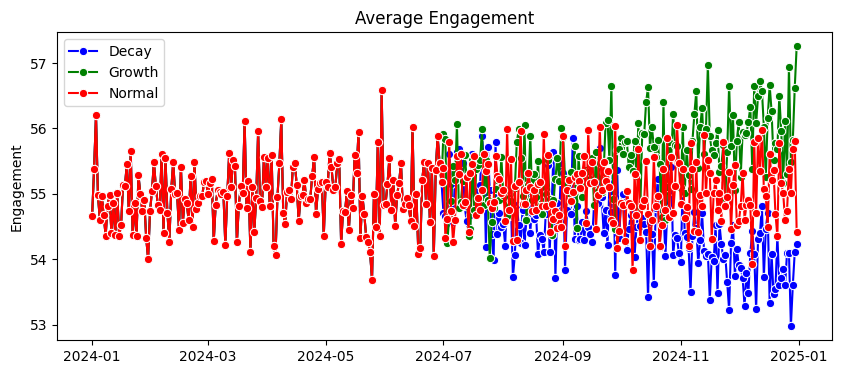

In [67]:
decay_avg_engagement = all_data_decay.groupby('Date')['Engagement'].mean()
growth_avg_engagement = all_data_growth.groupby('Date')['Engagement'].mean()
normal_avg_engagement = all_data_normal.groupby('Date')['Engagement'].mean()

all_dates = np.unique(all_data_decay['Date']).astype('datetime64[D]')



plt.figure(figsize=(10, 4))
sns.lineplot(x=all_dates, y=decay_avg_engagement, marker="o", label="Decay",color="Blue")
sns.lineplot(x=all_dates, y=growth_avg_engagement, marker="o", label="Growth",color="Green")
sns.lineplot(x=all_dates, y=normal_avg_engagement, marker="o", label="Normal",color="Red")
plt.title("Average Engagement")
plt.savefig(f"Charts/Engagement_Average.png")
plt.show()

Checking Daily Rolling Average On Multiple Window Lengths

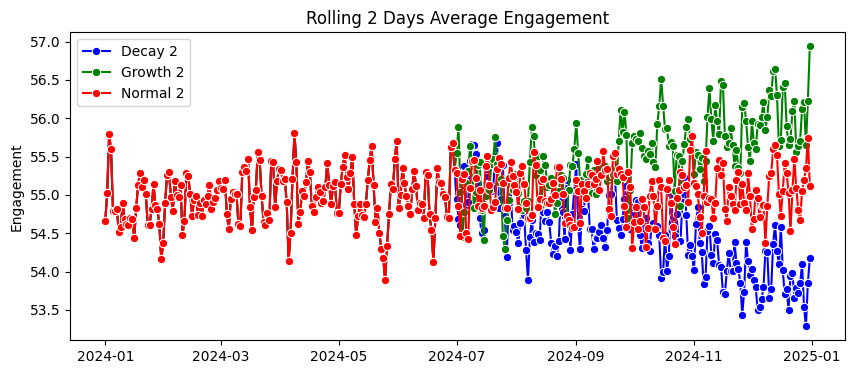

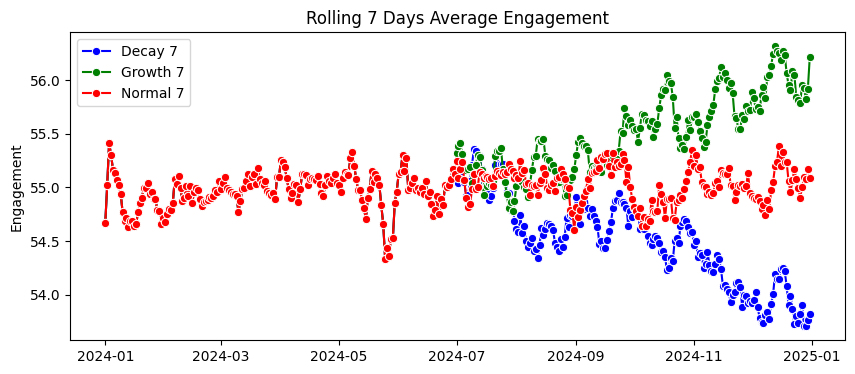

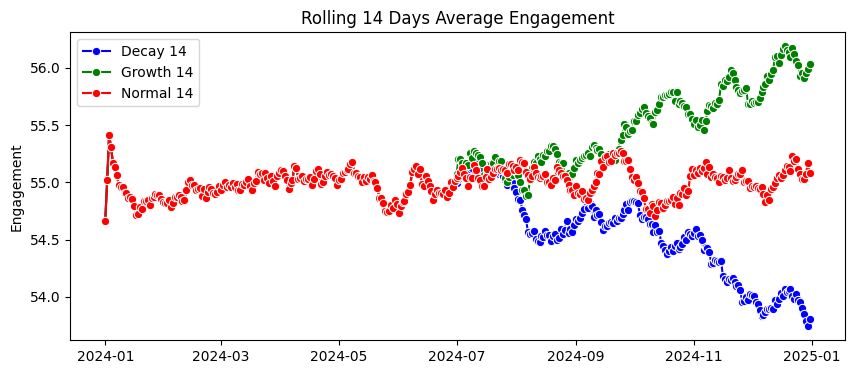

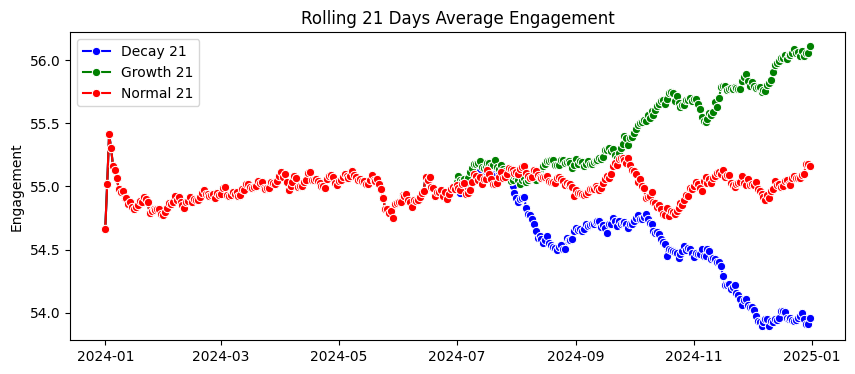

In [68]:
for rolling_val in [2,7,14,21]: 
    decay_rolling_avg_engagement = decay_avg_engagement.rolling(rolling_val,min_periods=1).mean()
    growth_rolling_avg_engagement = growth_avg_engagement.rolling(rolling_val,min_periods=1).mean()
    normal_rolling_avg_engagement = normal_avg_engagement.rolling(rolling_val,min_periods=1).mean()

    all_dates = np.unique(all_data_decay['Date']).astype('datetime64[D]')



    plt.figure(figsize=(10, 4))
    sns.lineplot(x=all_dates, y=decay_rolling_avg_engagement, marker="o", label=f"Decay {rolling_val}",color="Blue")
    sns.lineplot(x=all_dates, y=growth_rolling_avg_engagement, marker="o", label=f"Growth {rolling_val}",color="Green")
    sns.lineplot(x=all_dates, y=normal_rolling_avg_engagement, marker="o", label=f"Normal {rolling_val}",color="Red")
    plt.title(f"Rolling {rolling_val} Days Average Engagement")
    plt.savefig(f"Charts/Engagement_{rolling_val}_Days_Rolling_Average.png")
plt.show()

Comparing ADWIN performance on average, median, rolling average

In [ ]:
# Compute the time between each change point and product launch date, will be negative if a change is detected before the launch date
def delay_calculator(product_launch_date, change_points):
    product_launch_date = pd.Timestamp(product_launch_date)
    delays = [(pd.Timestamp(date) - product_launch_date).total_seconds() / 86400.0 for date, *_ in change_points]
    return delays

In [ ]:
#Test to check how well ADWIN performs on averages, median, and rolling average datasets, offers option to plot
def adwin_tests_2(adwin_model_avg, adwin_model_median, adwin_model_rolling_avg, df, target_column, product_launch_date, rolling_avg_days, scenario=None, show=False):

    #Run teh 
    def run_adwin_model(model, series):
        change_points = [] 
        i=0
        for date, val in series.items():
            model.update(val)
            if model.drift_detected and i>rolling_avg_days:
                change_points.append((date, val))
            i+=1
        return change_points


    def plot_changepoints(datastream, change_points, title_prefix, ylabel, save_suffix):

        series_before = datastream[datastream.index <= product_launch_date]
        series_after = datastream[datastream.index > product_launch_date]

        plt.figure(figsize=(10, 5))
        plt.plot(series_before.index, series_before.values, label=f"Time A (Daily {title_prefix})", color="cadetblue")
        plt.plot(series_after.index, series_after.values, label=f"Time B (Daily {title_prefix})", color="mediumslateblue")

        first_detected = None
        for cp_date, _ in change_points:
            if cp_date > product_launch_date and first_detected is None:
                color = "green"
                first_detected = cp_date
            else:
                color = "orange"
            plt.axvline(x=cp_date, color=color, linestyle="--", alpha=0.9, label="Change Point")

        plt.axvline(x=product_launch_date, color="red", linestyle="--", label="Product Launch")

        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys())
        plt.title(f"{title_prefix} {target_column} - ADWIN Change Detection ({scenario})")
        plt.xlabel("Date")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.tight_layout()

        filename = f"Charts/ADWIN_{scenario.replace(' ', '_')}_{save_suffix}_{target_column}.png"
        plt.savefig(filename)
        plt.show()

    #Main portion of function
    #Get the measures of the target
    
    avg_target = df.groupby('Date')[target_column].mean()
    median_target = df.groupby('Date')[target_column].median()
    avg_target_rolling = avg_target.rolling(rolling_avg_days,min_periods=1).mean()


    change_points_avg = run_adwin_model(adwin_model_avg, avg_target)
    change_points_median = run_adwin_model(adwin_model_median, median_target)
    change_points_rolling_avg = run_adwin_model(adwin_model_rolling_avg, avg_target_rolling)

    #Show plots
    if show:
        plot_changepoints(avg_target, change_points_avg, "Avg", f"Avg {target_column}", "Average")
        plot_changepoints(median_target, change_points_median, "Median", f"Median {target_column}", "Median")
        plot_changepoints(avg_target_rolling, change_points_rolling_avg, "Rolling Avg", f"Rolling Average {target_column}", "Rolling Average")

    # Calculate delays using delay_calculator (assumes delay_calculator and product_launch_date are defined)
    delay_avg = delay_calculator(product_launch_date, change_points_avg)
    delay_median = delay_calculator(product_launch_date, change_points_median)
    delay_rolling_avg = delay_calculator(product_launch_date, change_points_rolling_avg)

    return change_points_avg, change_points_median, change_points_rolling_avg, delay_avg, delay_median, delay_rolling_avg


Tuning of delta, min window legnth, and different rolling average days

In [ ]:
delta_range = [.5,.25, .15, .05, .02, .01, .005, .002, .001]
min_window_length_range = [1,2,5,10,15,20,50]
rolling_avg_days = [val for val in range(1,15)]
return_list_2 = []

def generate_adwin(delta_val,min_window_length_val):
    adwin = drift.ADWIN(delta = delta_val, # significance value
                            clock=1, # how often ADWIN should check for changes
                            min_window_length=min_window_length_val, #Min length allowed when checking concept drift, smaller may decrease delay but lead to false positives
                            grace_period=0)
    return adwin

for delta_val in delta_range:
    for min_window_length_val in min_window_length_range:
        for rolling_avg_val in rolling_avg_days:
            
            #Need to generate separate ADWIN model object for every run
            adwin_avg = generate_adwin(delta_val,min_window_length_val)
            adwin_median = generate_adwin(delta_val,min_window_length_val)
            adwin_rolling_avg = generate_adwin(delta_val,min_window_length_val)

            change_points_avg_decay, change_points_median_decay, change_points_rolling_avg_decay, \
                delay_avg_decay, delay_median_decay, delay_rolling_avg_decay = adwin_tests_2(adwin_avg, adwin_median, adwin_rolling_avg, 
                                                                                             all_data_decay, 'Engagement', product_launch_date,rolling_avg_val)
            
            adwin_avg = generate_adwin(delta_val,min_window_length_val)
            adwin_median = generate_adwin(delta_val,min_window_length_val)
            adwin_rolling_avg = generate_adwin(delta_val,min_window_length_val)

            change_points_avg_growth, change_points_median_growth, change_points_rolling_avg_growth, \
                delay_avg_growth, delay_median_growth,delay_rolling_avg_growth = adwin_tests_2(adwin_avg, adwin_median, adwin_rolling_avg, 
                                                                                               all_data_growth, 'Engagement', product_launch_date,rolling_avg_val)
            
            adwin_avg = generate_adwin(delta_val,min_window_length_val)
            adwin_median = generate_adwin(delta_val,min_window_length_val)
            adwin_rolling_avg = generate_adwin(delta_val,min_window_length_val)

            change_points_avg_decay, change_points_median_decay, change_points_rolling_avg_normal, \
                delay_avg_normal, delay_median_normal,delay_rolling_avg_normal = adwin_tests_2(adwin_avg, adwin_median, adwin_rolling_avg, 
                                                                                               all_data_normal, 'Engagement',product_launch_date,rolling_avg_val)
            
            return_list_2.append({"Delta Value": delta_val,
                                "Min Window Length": min_window_length_val,
                                "Rolling Avg Days": rolling_avg_val,
                                "Decay Change Detection Delay (Avg)": delay_avg_decay,
                                "Decay Change Point Detection Delay (Median)": delay_median_decay,
                                "Decay Change Point Detection Delay (Rolling Avg)": delay_rolling_avg_decay,
                                "Growth Change Detection Delay (Avg)": delay_avg_growth,
                                "Growth Change Point Detection Delay (Median)": delay_median_growth,
                                "Growth Change Point Detection Delay (Rolling Avg)": delay_rolling_avg_growth,
                                "Normal Change Detection Delay (Avg)": delay_avg_normal,
                                "Normal Change Point Detection Delay (Median)": delay_median_normal,
                                "Normal Change Point Detection Delay (Rolling Avg)": delay_rolling_avg_normal,
                                })




hyperparameter_tuning_2 = pd.DataFrame(return_list_2)  
hyperparameter_tuning_2
hyperparameter_tuning_2.to_csv('Charts/Hyperparameter_tuning.csv', index=False)


Change function to just look at rolling average and drop average and median

In [ ]:

def adwin_tests_3(adwin_model_rolling_avg, df, target_column, product_launch_date, rolling_avg_days, scenario=None, show=False):
    import numpy as np
    import matplotlib.pyplot as plt

    #Do not look
    def get_change_points(model, series):
        change_points = [] 
        i=0
        for date, val in series.items():
            model.update(val)
            if model.drift_detected and i>rolling_avg_days:
                change_points.append((date, val))
            i+=1
        return change_points


    def plot_changepoints(datastream, change_points, title_prefix, ylabel, save_suffix):
        series_before = datastream[datastream.index <= product_launch_date]
        series_after = datastream[datastream.index > product_launch_date]

        plt.figure(figsize=(10, 5))
        plt.plot(series_before.index, series_before.values, label="Time A (Daily Rolling Avg)", color="cadetblue")
        plt.plot(series_after.index, series_after.values, label="Time B (Daily Rolling Avg)", color="mediumslateblue")

        first_detected = None
        for cp_date, _ in change_points:
            if cp_date > product_launch_date and first_detected is None:
                color = "green"
                first_detected = cp_date
            else:
                color = "orange"
            plt.axvline(x=cp_date, color=color, linestyle="--", alpha=0.9, label="Change Point")


        plt.axvline(x=product_launch_date, color="red", linestyle="--", label="Product Launch")

        handles, labels = plt.gca().get_legend_handles_labels()
        unique = dict(zip(labels, handles))
        plt.legend(unique.values(), unique.keys())
        plt.title(f"{title_prefix} {target_column} - ADWIN Change Detection ({scenario})")
        plt.xlabel("Date")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.tight_layout()

        filename = f"Charts/ADWIN_{scenario.replace(' ', '_')}_{save_suffix}_{target_column}.png"
        plt.savefig(filename)
        plt.show()


    avg_target = df.groupby('Date')[target_column].mean()
    avg_target_rolling = avg_target.rolling(rolling_avg_days,min_periods=1).mean()


    change_points_rolling_avg = get_change_points(adwin_model_rolling_avg, avg_target_rolling)


    if show:
        plot_changepoints(avg_target_rolling, change_points_rolling_avg, "Rolling Avg", f"Rolling Average {target_column}", "Rolling Average")


    delay_rolling_avg = delay_calculator(product_launch_date, change_points_rolling_avg)

    return  change_points_rolling_avg, delay_rolling_avg

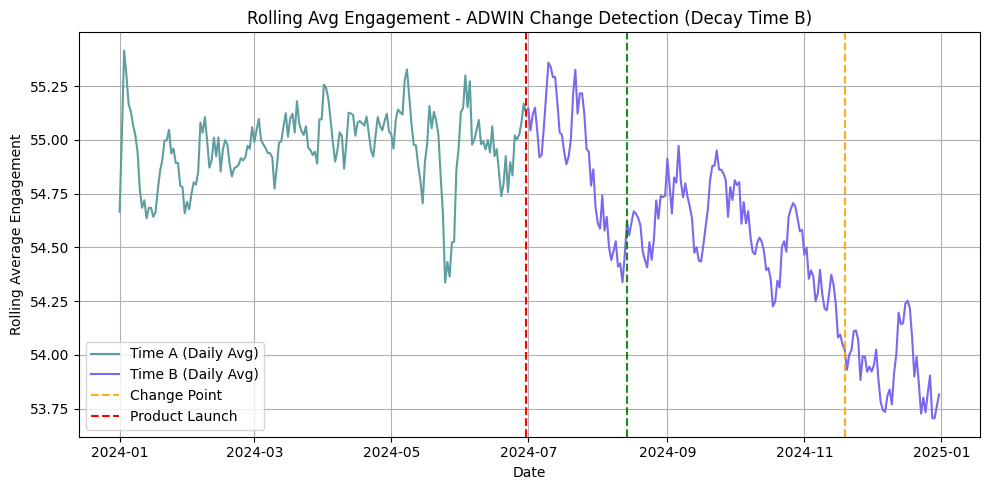

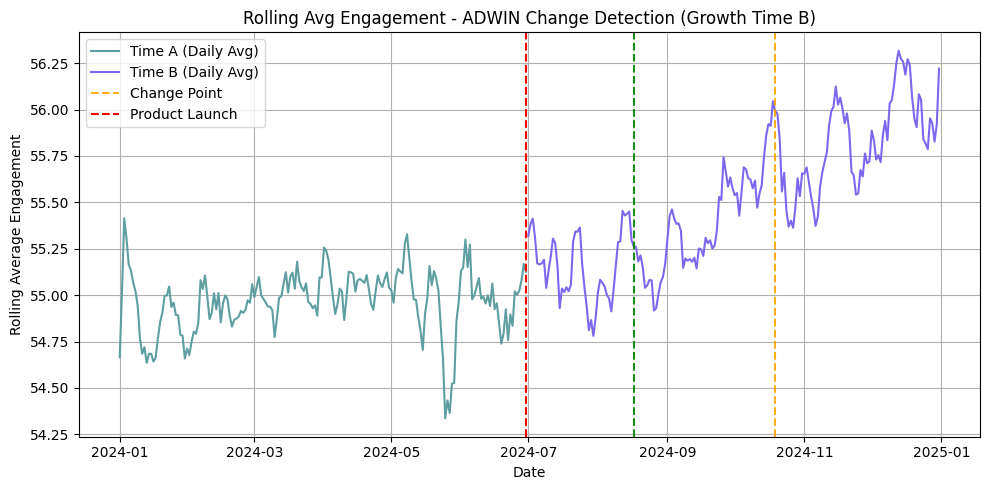

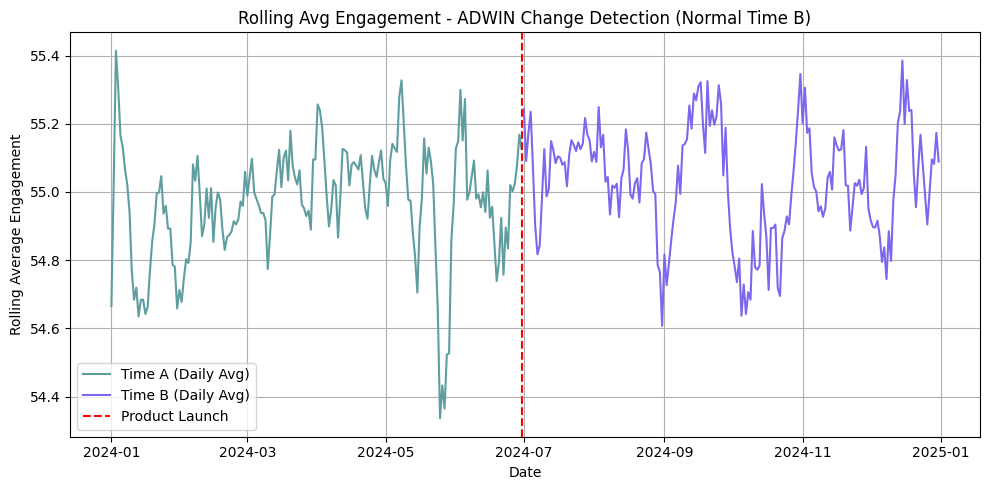

In [ ]:
##ADWIN paramaters based on hyperparameter tuning
def generate_adwin():
    adwin = drift.ADWIN(delta = .05, # significance value
                            clock=1, # how often ADWIN should check for changes
                            min_window_length=1, #Min length allowed when checking concept drift, smaller may decrease delay but lead to false positives
                            grace_period=0)
    return adwin


adwin_model = generate_adwin()
change_points_rolling_avg_decay, delay_rolling_avg_decay = adwin_tests_3(adwin_model, all_data_decay, 'Engagement', product_launch_date, 7,scenario="Decay Time B",show=True)

adwin_model = generate_adwin()
change_points_rolling_avg_growth, delay_rolling_avg_growth = adwin_tests_3(adwin_model, all_data_growth, 'Engagement', product_launch_date, 7,scenario="Growth Time B",show=True)
adwin_model = generate_adwin()
change_points_rolling_avg_normal, delay_rolling_avg_normal = adwin_tests_3(adwin_model, all_data_normal, 'Engagement', product_launch_date,7 ,scenario="Normal Time B",show=True)




Appendix

In [ ]:
def adwin_tests(adwin_model_avg, adwin_model_median, df, target_column,scenario=None,show=False):
    avg_target = df.groupby('Date')[target_column].mean()
    median_target = df.groupby('Date')[target_column].median()
    all_dates = np.unique(df['Date']).astype('datetime64[D]')


    change_points_avg = []
    for date, val in avg_target.items():
        adwin_model_avg.update(val)
        if adwin_model_avg.drift_detected:
            change_points_avg.append((date,val))

    change_points_median = []
    for date, val in median_target.items():
        adwin_model_median.update(val)
        if adwin_model_median.drift_detected:
            change_points_median.append((date,val))

    if show:
        
        # Average    
        daily_avg_a = avg_target[avg_target.index <= product_launch_date]
        daily_avg_b = avg_target[avg_target.index > product_launch_date]

        plt.figure(figsize=(10, 5))
        plt.plot(daily_avg_a.index, daily_avg_a.values, label="Time A (Daily Avg)", color="cadetblue")
        plt.plot(daily_avg_b.index, daily_avg_b.values, label="Time B (Daily Avg)", color="mediumslateblue")

        first_detected = None
        for cp in change_points_avg:
            color = "green" if (cp[0] > product_launch_date and first_detected is None) else "orange"
            if color == "green":
                first_detected = cp[0]
            plt.axvline(x=cp[0], color=color, linestyle="--", alpha=0.9, label="Change Point")

        plt.axvline(x=product_launch_date, color="red", linestyle="--", label="Product Launch")

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
       

        plt.title(f"Avg {target_column} - ADWIN Change Detection ({scenario})")
        plt.xlabel("Date")
        plt.ylabel(f"Avg {target_column}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"Charts/ADWIN_{scenario.replace(' ', '_')}_Average_{target_column}.png")
        plt.show()


        # Median
        daily_median_a = median_target[median_target.index <= product_launch_date]
        daily_median_b = median_target[median_target.index > product_launch_date]

        plt.figure(figsize=(10, 5))
        plt.plot(daily_median_a.index, daily_median_a.values, label="Time A (Daily Avg)", color="cadetblue")
        plt.plot(daily_median_b.index, daily_median_b.values, label="Time B (Daily Avg)", color="mediumslateblue")

        first_detected = None
        for cp in change_points_median:
            color = "green" if (cp[0] > product_launch_date and first_detected is None) else "orange"
            if color == "green":
                first_detected = cp[0]
            plt.axvline(x=cp[0], color=color, linestyle="--", alpha=0.9, label="Change Point")

        plt.axvline(x=product_launch_date, color="red", linestyle="--", label="Product Launch")

        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
       

        plt.title(f"Median {target_column} - ADWIN Change Detection ({scenario})")
        plt.xlabel("Date")
        plt.ylabel(f"Median {target_column}")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"Charts/ADWIN_{scenario.replace(' ', '_')}_Median_{target_column}.png")
        plt.show()


    delay_avg = delay_calculator(product_launch_date, change_points_avg)
    delay_median = delay_calculator(product_launch_date, change_points_median)

    return change_points_avg, change_points_median ,delay_avg, delay_median


In [ ]:
delta_range = [.5,.25, .15, .05, .02, .01, .005, .002, .001]
min_window_length_range = [1,2,5,10,15,20,50]
return_list = []


for delta_val in delta_range:
    for min_window_length_val in min_window_length_range:
        adwin_avg = drift.ADWIN(delta = delta_val, # significance value
                            clock=1, # how often ADWIN should check for changes
                            min_window_length=min_window_length_val, #Min length allowerd when checking concept drift, smaller may decrease delay but lead to false positives
                            grace_period=0) #when to start looking
        adwin_median = drift.ADWIN(delta = delta_val, # significance value
                            clock=1, # how often ADWIN should check for changes
                            min_window_length=min_window_length_val, #Min length allowerd when checking concept drift, smaller may decrease delay but lead to false positives
                            grace_period=0) #when to start looking
        change_points_avg_decay, change_points_median_decay, delay_avg_decay, delay_median_decay = adwin_tests(adwin_avg, adwin_median, all_data_decay, 'Engagement')
        change_points_avg_growth, change_points_median_growth, delay_avg_growth, delay_median_growth = adwin_tests(adwin_avg, adwin_median, all_data_growth, 'Engagement')
        change_points_avg_decay, change_points_median_decay, delay_avg_normal, delay_median_normal = adwin_tests(adwin_avg, adwin_median,all_data_normal, 'Engagement')
        return_list.append({"Delta Value": delta_val,
                            "Min Window Length": min_window_length_val,
                            "Decay Change Detection Delay (Avg)": delay_avg_decay,
                            "Decay Change Point Detection Delay (Median)": delay_median_decay,
                            "Growth Change Detection Delay (Avg)": delay_avg_growth,
                            "Growth Change Point Detection Delay (Median)": delay_median_growth,
                            "Normal Change Detection Delay (Avg)": delay_avg_normal,
                            "Normal Change Point Detection Delay (Median)": delay_median_normal,
                            })




hyperparameter_tuning = pd.DataFrame(return_list)  
hyperparameter_tuning

In [ ]:
def generate_adwin():
    adwin = drift.ADWIN(delta = .5, # significance value
                            clock=1, # how often ADWIN should check for changes
                            min_window_length=1, #Min length allowed when checking concept drift, smaller may decrease delay but lead to false positives
                            grace_period=0)
    return adwin

adwin_avg = generate_adwin()
adwin_median = generate_adwin()
change_points_avg_decay, change_points_median_decay, delay_avg_decay, delay_median_decay = adwin_tests(adwin_avg, adwin_median, all_data_decay, 'Engagement', scenario="Decay Time B",show=True)
adwin_avg = generate_adwin()
adwin_median = generate_adwin()
change_points_avg_growth, change_points_median_growth, delay_avg_growth, delay_median_growth = adwin_tests(adwin_avg, adwin_median, all_data_growth, 'Engagement', scenario="Growth Time B",show=True)
adwin_avg = generate_adwin()
adwin_median = generate_adwin()
change_points_avg_normal, change_points_median_normal, delay_avg_normal, delay_median_normal = adwin_tests(adwin_avg, adwin_median, all_data_normal, 'Engagement', scenario="Normal Time B",show=True)

Change detected at index 288, input value: 48.402587548652285
1


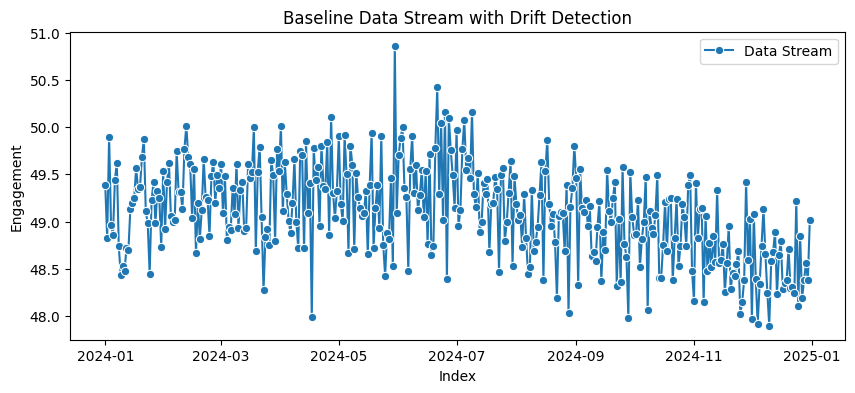

Change detected at index 314, input value: 38.18465455200966
1


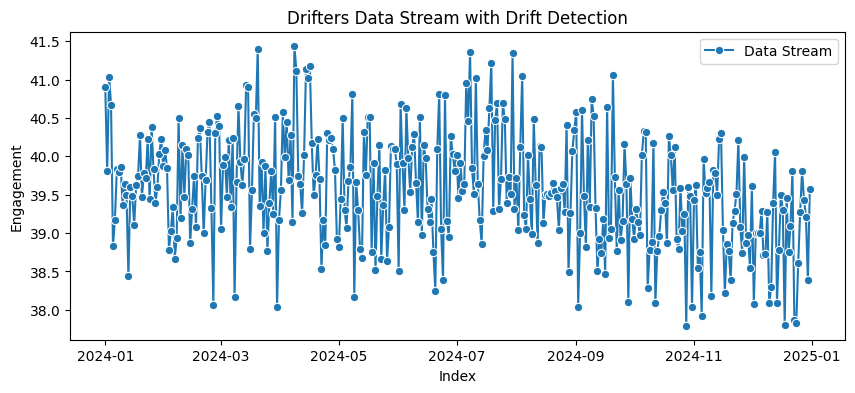

Change detected at index 330, input value: 84.32861766447058
1


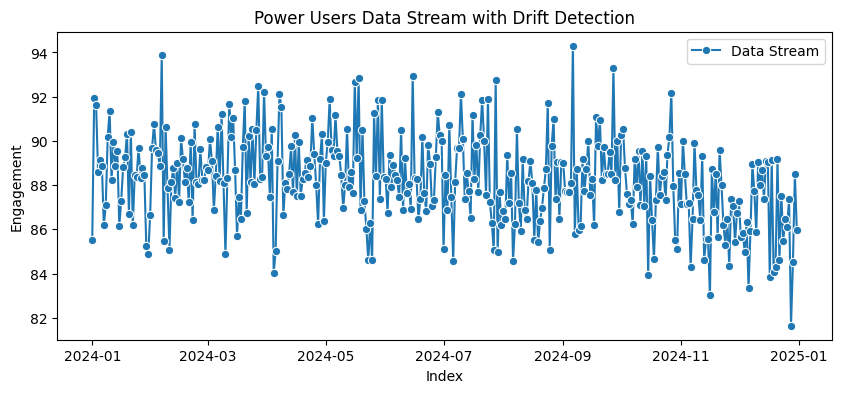

In [ ]:
# def delay_calculator(product_launch_date, change_points):
#     product_launch_date = pd.Timestamp(product_launch_date)
#     dates_after_launch = [val[0] for val in change_points if val[0] > product_launch_date]
#     if dates_after_launch:
#         delay = min(dates_after_launch) - product_launch_date
#     else:
#         delay=None
#     return delay


all_ctr = all_data_decay['CTR']
all_engagement = all_data_decay['Engagement']

avg_ctr = all_data_decay.groupby('Date')['CTR'].mean()



#Look how well it works against different groups
user_groups = {user_id: group for user_id, group in all_data_decay.groupby('Group')}


for group_name, group in user_groups.items():

    avg_engagement = group.groupby('Date')['Engagement'].mean()
    group_dates = avg_engagement.index



    #WANT TO ADJUST THIS ADWIN
    adwin_by_group = drift.ADWIN(delta = .01,
                    clock=1,
                    min_window_length=1,
                    grace_period=5) # Create a new ADWIN instance for this user
    
    change_points = [] 

    data_stream = list(avg_engagement)

    change_points = []
    for i, val in enumerate(data_stream):
        adwin_by_group.update(val)
        if adwin_by_group.drift_detected:
            print(f"Change detected at index {i}, input value: {val}")
            print(adwin_by_group.n_detections)
            change_points.append((i,val))


    plt.figure(figsize=(10, 4))
    sns.lineplot(x=group_dates, y=avg_engagement, marker="o", label="Data Stream")


    for idx, val in change_points:
        plt.annotate(
            f"Change at {idx}", 
            xy=(idx, val), 
            xytext=(idx, val + 1),
            arrowprops=dict(arrowstyle="->", lw=1.5),
            fontsize=9
        )

    plt.title(f"{group_name} Data Stream with Drift Detection")
    plt.xlabel("Index")
    plt.ylabel("Engagement")
    plt.legend()
    plt.show()

In [ ]:
avg_engagement = all_data_decay.groupby('Date')['Engagement'].mean()

plt.figure(figsize=(10, 4))
sns.lineplot(x=all_dates, y=avg_engagement, marker="o", label="Engagement")


df = all_data_decay
target_column = 'Engagement'
all_dates = np.unique(all_data_decay['Date']).astype('datetime64[D]')

adwin = drift.ADWIN(delta = .05, # significance value
                    clock=1, # how often ADWIN should check for changes
                    min_window_length=5, #Min length allowerd when checking concept drift, smaller may decrease delay but lead to false positives
                    grace_period=0) #when to start looking

change_points_avg, change_points_median, delay_avg, delay_median = adwin_tests(adwin, all_data_decay,'Engagement',scenario="Decay", show=True)

hyperparameter_tuning['Decay Change Detection Delay (Avg)']/ pd.Timedelta(days=1)

0      43.0
1      44.0
2      50.0
3      52.0
4      59.0
5      71.0
6      50.0
7      50.0
8      52.0
9      59.0
10     72.0
11     76.0
12     52.0
13     52.0
14     53.0
15     72.0
16     76.0
17     79.0
18     73.0
19     74.0
20     76.0
21     78.0
22     98.0
23    101.0
24     78.0
25     97.0
26    100.0
27    101.0
28    106.0
29    107.0
30    101.0
31    102.0
32    105.0
33    107.0
34    109.0
35    110.0
36    107.0
37    107.0
38    107.0
39    110.0
40    115.0
41    121.0
42    110.0
43    110.0
44    116.0
45    122.0
46    124.0
47    128.0
48    122.0
49    122.0
50    123.0
51    127.0
52    129.0
53    131.0
Name: Decay Change Detection Delay (Avg), dtype: float64